# Ensemble



In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

In [2]:
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
import seaborn as sns


import warnings
import itertools
from PIL import Image
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix, classification_report


# !pip install visualkeras
import tensorflow as tf
import visualkeras
import matplotlib.pyplot as plt
from sklearn.metrics import multilabel_confusion_matrix

from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import plot_model
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from sklearn.model_selection   import train_test_split
from keras.preprocessing.image import ImageDataGenerator

warnings.filterwarnings('ignore')
%matplotlib inline

In [3]:
import numpy as np
from tensorflow.keras.layers import Input, Lambda, Bidirectional, LSTM, Dense, concatenate
from tensorflow.keras.models import Model
from sklearn.ensemble import StackingClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import precision_recall_fscore_support
import matplotlib.pyplot as plt

**Load images**

In [4]:
# pip install opencv-python
import cv2
import os

folder_path = "ds_two"             # base/root directory

no_tumor = os.listdir(folder_path + '/no_tumor/')
glioma = os.listdir(folder_path + '/glioma/')
meningioma = os.listdir(folder_path + '/meningioma/')
pituitary = os.listdir(folder_path + '/pituitary/')
craniopharyngioma = os.listdir(folder_path + '/craniopharyngioma_final_1070/')

dataset=[]
lab=[]

In [5]:
for image_name in no_tumor:
    image=cv2.imread(folder_path + '/no_tumor/' + image_name)
    image=Image.fromarray(image,'RGB')
    image=image.resize((240,240))
    dataset.append(np.array(image))
    lab.append(0)

In [6]:
for image_name in glioma:
    image=cv2.imread(folder_path + '/glioma/' + image_name)
    image=Image.fromarray(image,'RGB')
    image=image.resize((240,240))
    dataset.append(np.array(image))
    lab.append(1)

In [7]:
for image_name in meningioma:
    image=cv2.imread(folder_path + '/meningioma/' + image_name)
    image=Image.fromarray(image,'RGB')
    image=image.resize((240,240))
    dataset.append(np.array(image))
    lab.append(2)

In [8]:
for image_name in pituitary:
    image=cv2.imread(folder_path + '/pituitary/' + image_name)
    image=Image.fromarray(image,'RGB')
    image=image.resize((240,240))
    dataset.append(np.array(image))
    lab.append(3)

In [9]:
for image_name in craniopharyngioma:
    image=cv2.imread(folder_path + '/craniopharyngioma_final_1070/' + image_name)
    image=Image.fromarray(image,'RGB')
    image=image.resize((240,240))
    dataset.append(np.array(image))
    lab.append(4)

In [10]:
dataset = np.array(dataset)
lab = np.array(lab)
print(dataset.shape, lab.shape)

(8103, 240, 240, 3) (8103,)


In [11]:
x_train, x_test, y_train, y_test = train_test_split(dataset, lab, test_size=0.2, shuffle=True, random_state=42)

print('Training data and target sizes: \n{}, {}'.format(x_train.shape,y_train.shape))
print('Test data and target sizes: \n{}, {}'.format(x_test.shape,y_test.shape))

Training data and target sizes: 
(6482, 240, 240, 3), (6482,)
Test data and target sizes: 
(1621, 240, 240, 3), (1621,)


In [12]:
x_train = x_train / 255
x_test = x_test / 255

In [13]:
x_train.shape, x_test.shape

((6482, 240, 240, 3), (1621, 240, 240, 3))

In [14]:
y_train.shape, y_test.shape

((6482,), (1621,))

In [16]:
y_train.shape, y_test.shape

((6482,), (1621,))

In [18]:
from keras.preprocessing.image import ImageDataGenerator

**Data augmentation**

In [19]:
augment = ImageDataGenerator(
                             rotation_range=20,
                              width_shift_range=0.01,
                              height_shift_range=0.01,
                              horizontal_flip=False,
                              vertical_flip=False,
                            )
augment.fit(x_train)

In [20]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2

**Deep Ensemble**

VGG16, DenseNet and InceptionNet

In [21]:
model = VGG16(include_top = False, weights = 'imagenet', input_shape = (240,240,3))

In [22]:
model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 240, 240, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 240, 240, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 240, 240, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 120, 120, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 120, 120, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 120, 120, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 60, 60, 128)       0     

In [23]:
for ix in range(len(model.layers)):
    print(ix,model.layers[ix])

0 <keras.engine.input_layer.InputLayer object at 0x0000023065043A60>
1 <keras.layers.convolutional.Conv2D object at 0x000002306C2C0D90>
2 <keras.layers.convolutional.Conv2D object at 0x000002306C3373D0>
3 <keras.layers.pooling.MaxPooling2D object at 0x000002303C4F57F0>
4 <keras.layers.convolutional.Conv2D object at 0x000002303C4EDCA0>
5 <keras.layers.convolutional.Conv2D object at 0x000002303C4FC1F0>
6 <keras.layers.pooling.MaxPooling2D object at 0x000002303C50CF10>
7 <keras.layers.convolutional.Conv2D object at 0x000002303C50AA60>
8 <keras.layers.convolutional.Conv2D object at 0x000002303C515160>
9 <keras.layers.convolutional.Conv2D object at 0x000002303C50C070>
10 <keras.layers.pooling.MaxPooling2D object at 0x000002303C51B8E0>
11 <keras.layers.convolutional.Conv2D object at 0x000002303C538100>
12 <keras.layers.convolutional.Conv2D object at 0x000002303C538460>
13 <keras.layers.convolutional.Conv2D object at 0x000002303C531790>
14 <keras.layers.pooling.MaxPooling2D object at 0x000002

**Fine-Tuninng**

In [24]:
for layer in model.layers[:16]:
    layer.trainable = False
for i, layer in enumerate(model.layers):
    print(i, layer.name, layer.trainable)


0 input_1 False
1 block1_conv1 False
2 block1_conv2 False
3 block1_pool False
4 block2_conv1 False
5 block2_conv2 False
6 block2_pool False
7 block3_conv1 False
8 block3_conv2 False
9 block3_conv3 False
10 block3_pool False
11 block4_conv1 False
12 block4_conv2 False
13 block4_conv3 False
14 block4_pool False
15 block5_conv1 False
16 block5_conv2 True
17 block5_conv3 True
18 block5_pool True


In [25]:
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Model

# Define the input layer
input_layer = Input(shape=(240, 240, 3))


av1 = Flatten()(input_layer)
fc1 = Dense(256, activation='relu', kernel_regularizer=l2(0.01))(av1)
d1 = Dropout(0.5)(fc1)
fc2 = Dense(128, activation='relu', kernel_regularizer=l2(0.01))(d1)
d2 = Dropout(0.5)(fc2)
fc3 = Dense(5, activation='softmax')(d2)

# Create the model
model_vgg = Model(input_layer, fc3)
model_vgg.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 240, 240, 3)]     0         
_________________________________________________________________
flatten (Flatten)            (None, 172800)            0         
_________________________________________________________________
dense (Dense)                (None, 256)               44237056  
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 645   

## DenseNet201

In [26]:
from tensorflow.keras.applications import DenseNet201

model_dense = DenseNet201(weights='imagenet', include_top=False, input_shape=(240, 240, 3))

from tensorflow.keras.applications.densenet import preprocess_input

dataset = preprocess_input(np.array(dataset))

In [28]:
model_dense.summary()

Model: "densenet201"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 240, 240, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 246, 246, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 120, 120, 64) 9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 120, 120, 64) 256         conv1/conv[0][0]                 
________________________________________________________________________________________

In [29]:
for ix in range(len(model_dense.layers)):
    print(ix,model_dense.layers[ix])

0 <keras.engine.input_layer.InputLayer object at 0x00000230653E1850>
1 <keras.layers.convolutional.ZeroPadding2D object at 0x000002303C50CC10>
2 <keras.layers.convolutional.Conv2D object at 0x000002303C50A310>
3 <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x000002303C60B040>
4 <keras.layers.core.Activation object at 0x000002303C503100>
5 <keras.layers.convolutional.ZeroPadding2D object at 0x000002303C6124C0>
6 <keras.layers.pooling.MaxPooling2D object at 0x000002303C73FC70>
7 <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x000002303C73AF10>
8 <keras.layers.core.Activation object at 0x000002303C73AEB0>
9 <keras.layers.convolutional.Conv2D object at 0x000002303C7513D0>
10 <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x000002303C751820>
11 <keras.layers.core.Activation object at 0x000002303C751070>
12 <keras.layers.convolutional.Conv2D object at 0x000002303C75E5B0>
13 <keras.layers.merge.Concat

**Fine-Tuning**

In [30]:
for layer in model_dense.layers[:169]:
    layer.trainable = False
for i, layer in enumerate(model_dense.layers):
    print(i, layer.name, layer.trainable)

0 input_3 False
1 zero_padding2d False
2 conv1/conv False
3 conv1/bn False
4 conv1/relu False
5 zero_padding2d_1 False
6 pool1 False
7 conv2_block1_0_bn False
8 conv2_block1_0_relu False
9 conv2_block1_1_conv False
10 conv2_block1_1_bn False
11 conv2_block1_1_relu False
12 conv2_block1_2_conv False
13 conv2_block1_concat False
14 conv2_block2_0_bn False
15 conv2_block2_0_relu False
16 conv2_block2_1_conv False
17 conv2_block2_1_bn False
18 conv2_block2_1_relu False
19 conv2_block2_2_conv False
20 conv2_block2_concat False
21 conv2_block3_0_bn False
22 conv2_block3_0_relu False
23 conv2_block3_1_conv False
24 conv2_block3_1_bn False
25 conv2_block3_1_relu False
26 conv2_block3_2_conv False
27 conv2_block3_concat False
28 conv2_block4_0_bn False
29 conv2_block4_0_relu False
30 conv2_block4_1_conv False
31 conv2_block4_1_bn False
32 conv2_block4_1_relu False
33 conv2_block4_2_conv False
34 conv2_block4_concat False
35 conv2_block5_0_bn False
36 conv2_block5_0_relu False
37 conv2_block5_1_

In [31]:
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Model

# Define the input layer
input_layer = Input(shape=(240, 240, 3))

# model architecture
av1 = Flatten()(input_layer)
fc1 = Dense(256, activation='relu', kernel_regularizer=l2(0.01))(av1)
d1 = Dropout(0.5)(fc1)
fc2 = Dense(128, activation='relu', kernel_regularizer=l2(0.01))(d1)
d2 = Dropout(0.5)(fc2)
fc3 = Dense(5, activation='softmax')(d2)

# Create the model
model_dense = Model(input_layer, fc3)
model_dense.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 240, 240, 3)]     0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 172800)            0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               44237056  
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 5)                 645 

## InceptionResNetV2

In [32]:
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Model
from tensorflow.keras.applications.inception_resnet_v2 import preprocess_input

In [33]:
# Load the InceptionResNetV2 model pre-trained on ImageNet data
base_model = InceptionResNetV2(weights='imagenet', include_top=False, input_shape=(240, 240, 3))

In [34]:
# Freeze layers of the pre-trained model
for layer in base_model.layers:
    layer.trainable = False

In [35]:
# Define the input layer
input_layer = Input(shape=(240, 240, 3))

In [36]:
# Get the output of the base InceptionResNetV2 model
base_output = base_model(input_layer)

In [37]:
flatten_layer = Flatten()(base_output)
dense_layer1 = Dense(256, activation='relu', kernel_regularizer=l2(0.01))(flatten_layer)
dropout_layer1 = Dropout(0.5)(dense_layer1)
dense_layer2 = Dense(128, activation='relu', kernel_regularizer=l2(0.01))(dropout_layer1)
dropout_layer2 = Dropout(0.5)(dense_layer2)
output_layer = Dense(5, activation='softmax')(dropout_layer2)

In [38]:
# Create the final model
model_inceptionRNV2 = Model(inputs=input_layer, outputs=output_layer)

In [39]:
# Print model summary
model_inceptionRNV2.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 240, 240, 3)]     0         
_________________________________________________________________
inception_resnet_v2 (Functio (None, 6, 6, 1536)        54336736  
_________________________________________________________________
flatten_2 (Flatten)          (None, 55296)             0         
_________________________________________________________________
dense_6 (Dense)              (None, 256)               14156032  
_________________________________________________________________
dropout_4 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_5 (Dropout)          (None, 128)               0   

**Average-Layer**

In [41]:
import tensorflow as tf

models = [model_vgg, model_dense, model_inceptionRNV2]

model_input = tf.keras.Input(shape=(240, 240, 3))
model_outputs = [model(model_input) for model in models]
ensemble_output = tf.keras.layers.Average()(model_outputs)
ensemble_model = tf.keras.models.Model(inputs=model_input, outputs=ensemble_output, name='ensemble')

In [42]:
ensemble_model.summary()

Model: "ensemble"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 240, 240, 3) 0                                            
__________________________________________________________________________________________________
model (Functional)              (None, 5)            44270597    input_7[0][0]                    
__________________________________________________________________________________________________
model_1 (Functional)            (None, 5)            44270597    input_7[0][0]                    
__________________________________________________________________________________________________
model_2 (Functional)            (None, 5)            68526309    input_7[0][0]                    
___________________________________________________________________________________________

In [43]:
adam = Adam(learning_rate=0.0001)
ensemble_model.compile(loss='sparse_categorical_crossentropy',optimizer = adam,metrics=['accuracy'])

In [44]:
tf.keras.utils.plot_model(ensemble_model, 'ensemble_model.png', show_shapes= True)

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


**Model Training**

In [48]:
y_train.shape

(6482,)

In [49]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint

early_stop = EarlyStopping(monitor='val_accuracy', patience=10)

model_checkpoint_callback = ModelCheckpoint(
    filepath = "dl_ensemble.h5",
    monitor="val_accuracy",
    save_best_only=True,
)

In [50]:
history = ensemble_model.fit(
            x_train,
            y_train,
            shuffle = True,
            batch_size= 32,
            epochs = 100,
            validation_data = (x_test, y_test),
            callbacks=[early_stop, model_checkpoint_callback])

Epoch 1/100
203/203 [==============================] - 346s 2s/step - loss: 13.4443 - accuracy: 0.3593 - val_loss: 8.9873 - val_accuracy: 0.4997
Epoch 2/100
203/203 [==============================] - 337s 2s/step - loss: 7.5802 - accuracy: 0.3971 - val_loss: 6.1445 - val_accuracy: 0.4164
Epoch 3/100
203/203 [==============================] - 345s 2s/step - loss: 5.4744 - accuracy: 0.5026 - val_loss: 4.6898 - val_accuracy: 0.6823
Epoch 4/100
203/203 [==============================] - 328s 2s/step - loss: 4.2628 - accuracy: 0.6731 - val_loss: 3.6996 - val_accuracy: 0.7730
Epoch 5/100
203/203 [==============================] - 331s 2s/step - loss: 3.5212 - accuracy: 0.7302 - val_loss: 3.1151 - val_accuracy: 0.8044
Epoch 6/100
203/203 [==============================] - 334s 2s/step - loss: 3.0112 - accuracy: 0.7382 - val_loss: 2.6870 - val_accuracy: 0.8347
Epoch 7/100
203/203 [==============================] - 335s 2s/step - loss: 2.6568 - accuracy: 0.7541 - val_loss: 2.4005 - val_accuracy

In [51]:
ensemble_model = tf.keras.models.load_model("dl_ensemble.h5")

ensemble_model.evaluate(x_test,y_test)

51/51 [==============================] - 58s 1s/step - loss: 1.1547 - accuracy: 0.9112


[1.1547114849090576, 0.9111659526824951]

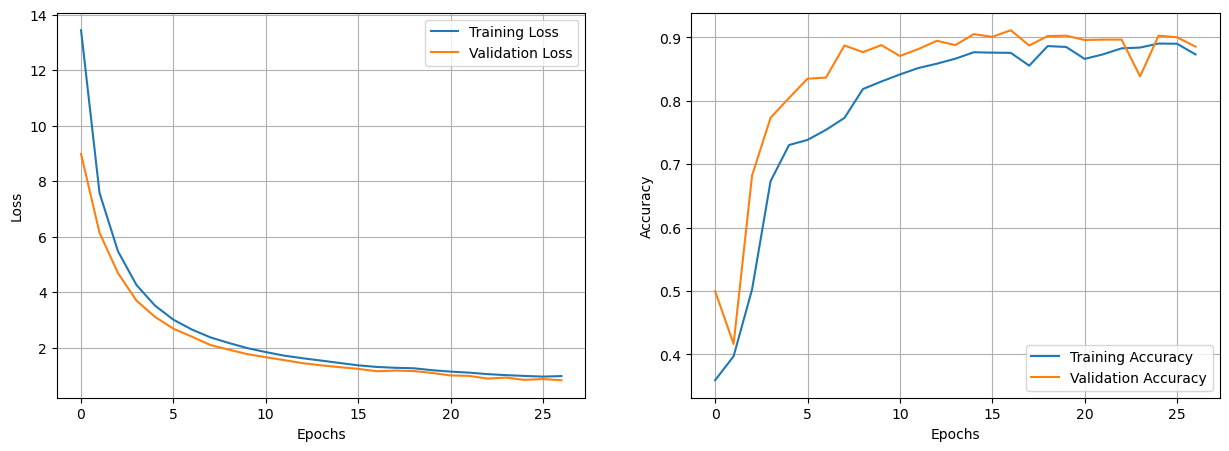

In [52]:
plt.figure(1, figsize = (15, 5))
plt.subplot(1,2,1)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.plot( history.history["loss"], label = "Training Loss")
plt.plot( history.history["val_loss"], label = "Validation Loss")
plt.grid(True)
plt.legend()

plt.subplot(1,2,2)
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.plot( history.history["accuracy"], label = "Training Accuracy")
plt.plot( history.history["val_accuracy"], label = "Validation Accuracy")
plt.grid(True)
plt.legend()

**Testing Ensemble Model**

In [53]:
from sklearn.metrics import classification_report

y_pred = ensemble_model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)

In [54]:
print(y_pred_classes.shape, y_test.shape)

(1621,) (1621,)


In [55]:
class_names = ['no_tumor', 'glioma', 'meningioma', 'pituitary', 'craniopharyngioma_final_1070']

classification_rep = classification_report(y_test, y_pred_classes, target_names=class_names)

# Print classification report
print(classification_rep)

                              precision    recall  f1-score   support

                    no_tumor       0.95      0.95      0.95       414
                      glioma       0.91      0.89      0.90       335
                  meningioma       0.84      0.76      0.80       339
                   pituitary       0.88      1.00      0.93       345
craniopharyngioma_final_1070       0.99      0.97      0.98       188

                    accuracy                           0.91      1621
                   macro avg       0.92      0.91      0.91      1621
                weighted avg       0.91      0.91      0.91      1621



In [56]:
from sklearn.metrics import r2_score
r2_score(y_test, y_pred_classes)

0.8999150569903981

In [57]:
from sklearn.metrics import confusion_matrix
import pandas as pd

cm = confusion_matrix(y_test, y_pred_classes)
cm_df = pd.DataFrame(cm,
                     index = ['no_tumor', 'glioma', 'meningioma', 'pituitary', 'craniopharyngioma_final_1070'],

                     columns = ['no_tumor', 'glioma', 'meningioma', 'pituitary', 'craniopharyngioma_final_1070'])

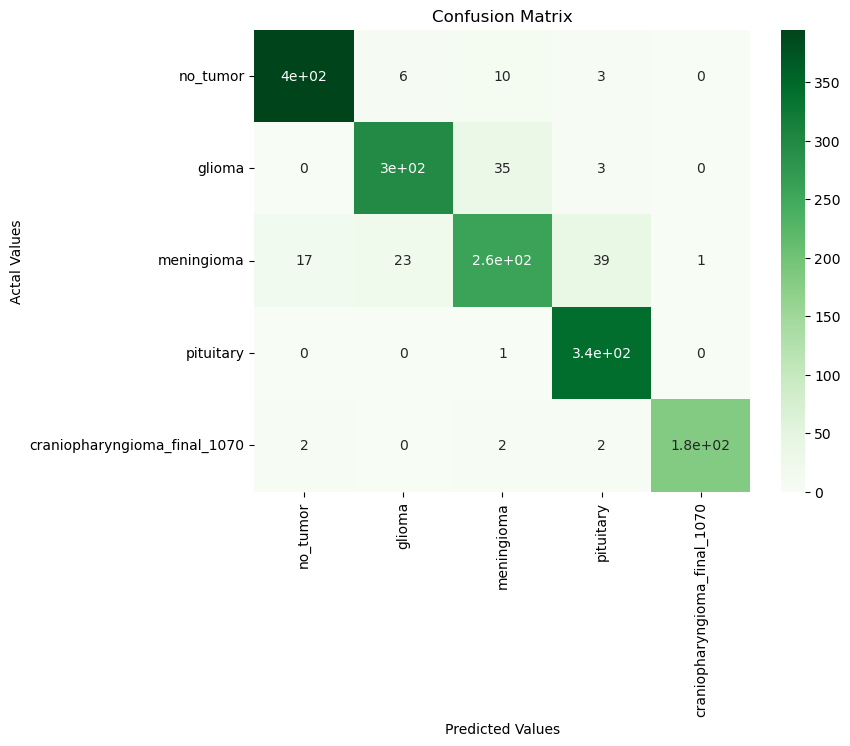

In [58]:
import seaborn as sns
plt.figure(figsize=(8,6))
sns.heatmap(cm_df, annot=True,cmap="Greens")
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

In [67]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_pred_classes)

0.9111659469463295

In [74]:
from sklearn.metrics import precision_score
precision_score(y_test, y_pred_classes,average='macro')

0.9166256697985377

In [75]:
from sklearn.metrics import recall_score
recall_score(y_test, y_pred_classes,average='macro')

0.9139743598881424

In [76]:
from sklearn.metrics import f1_score
f1_score(y_test, y_pred_classes,average='macro')

0.9141033952252459

In [77]:
from sklearn.metrics import precision_score
precision_score(y_test, y_pred_classes,average='micro')

0.9111659469463295

In [78]:
from sklearn.metrics import recall_score
recall_score(y_test, y_pred_classes,average='micro')

0.9111659469463295

In [79]:
from sklearn.metrics import f1_score
f1_score(y_test, y_pred_classes,average='micro')

0.9111659469463295

In [80]:
from sklearn.metrics import precision_score
precision_score(y_test, y_pred_classes,average='weighted')

0.9109797770107413

In [81]:
from sklearn.metrics import recall_score
recall_score(y_test, y_pred_classes,average='weighted')

0.9111659469463295

In [82]:
from sklearn.metrics import f1_score
f1_score(y_test, y_pred_classes,average='weighted')

0.9098250613638044